# Проект: принятие решений в бизнесе

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовила список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты. 

### Структура данных:
    
#### Данные для первой части 
*Файл /datasets/hypothesis.csv*

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части
*Файл /datasets/orders.csv*

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

*Файл /datasets/visitors.csv* 

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Изучение и предобработка данных 

#### 1. Загружаем библиотеки и изучаем данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#следующие библиотеки понадобятся для проверки гипотез и анализа A/B-тестов
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [3]:
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

#### 2. Предобработка данных

In [4]:
#здесь и далее проверяем на скрытые дубликаты 
hypothesis.duplicated().sum()

0

In [5]:
orders.duplicated().sum()

0

In [6]:
visitors.duplicated().sum()

0

In [7]:
#преобразовываем типы данных, где это необходимо
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [8]:
#удостоверимся, что даты в датасетах `visitors` и `orders` совпадают 
visitors.agg({'date': ['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


In [9]:
orders.agg({'date': ['min', 'max']})

,date
min,2019-08-01
max,2019-08-31


In [10]:
#удостоверимся, что тип данных в столбцах `date` датасетов visitors и orders был заменен корректно
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


По результатам предварительного анализа установлено, что в данных отсутствуют пропуски и дубликаты. Мы заменили тип данных в столбцах `date` датасетов orders и visitors. Установили, что минимальные и максимальные даты в указанных датасетах совпадают, - мы анализируем данные за август 2019 года. 

### Приоритизация гипотез

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Ниже рассчитаем фреймворки **ICE** и **RICE**.

ICE рассчитаем по следующей формуле: (Impact * Confidence)/Efforts

RICE будем рассчитывать по следующей формуле: (Reach * Impact * Confidence)/Efforts

In [11]:
#прежде, чем начать приоритизировать гипотезы, выведем датасет hypothesis и посмотрим на значения
pd.options.display.max_colwidth = 120
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### 3. Применяем фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [12]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE: 
1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
2. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
3. Запустить акцию, дающую скидку на товар в день рождения.

#### 4. Применяем фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [13]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: 
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Приоритизация гипотез изменилась при применении RICE вместо ICE из-за использования при расчетах параметра Reach. У вырвавшейся вперед при расчете с помощью фреймворка RICE гипотезы показатель Reach равен 10. 
Для тестирования предлагается взять следующую гипотезу: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

### Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

#### 5. Проверим гипотезу о равенстве долей

In [14]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))


Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


In [15]:
alpha = .05 #критический уровень статистической значимости

successes = np.array([557, 640])
trials = np.array([18736, 18916])

#пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

#пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима')
else:
    print(
        'Разница в количестве посетителей в группах A и B статистически не значима'
    ) 

p-значение:  0.02320723394441848
Разница в количестве посетителей в группах A и B статистически значима


In [16]:
#проверяем наличие пользователей, которые попадают в обе группы
cross_users = orders.groupby('visitorId').agg({'group': pd.Series.nunique}).query('group > 1')
print(cross_users.count())

group    58
dtype: int64


По дизайну теста пользователи разбивались на равные группы, но по неизвестной причине некоторые пользователи попали сразу в 2 группы: в реальной жизни нужно идти и разбираться, правда ли это не смещает выборки. Ниже все метрики рассчитываем с учетом пересекающихся пользователей, в самом конце работы удалим пересекающихся пользователей и посмотрим, влияют ли они на метрики.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами:

`date` — дата;

`group` — группа A/B-теста (A или B);

`orders` — кумулятивное количество заказов на указанную дату в указанной группе;

`buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;

`revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);

`visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#выводим кумулятивные показатели из orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group']==x['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1).sort_values(by=['date', 'group'])

#выводим кумулятивные показатели из visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group']==x['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1).sort_values(by=['date', 'group'])
#сводим все накопительные данные в одну таблицу

#собрали накопительные данные
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


#### 6. Строим график кумулятивной выручки по группам. Делаем выводы и предположения.

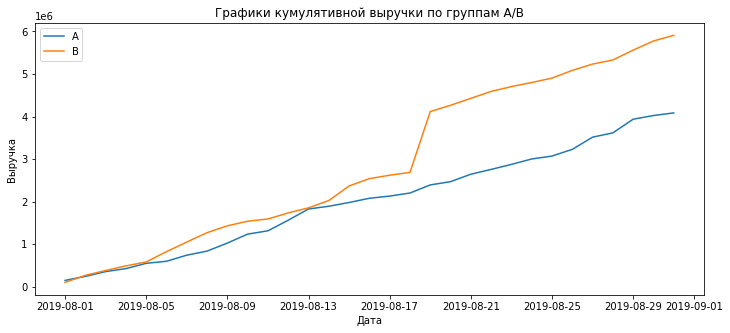

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend() 
plt.show()

Группа B стабильно показывает более высокие показатели выручки. Однако "18" августа видим аномалию на графике - резкий рост кумулятивной выручки в группе B.

#### 7. Строим график кумулятивного среднего чека по группам. Делаем выводы и предположения.

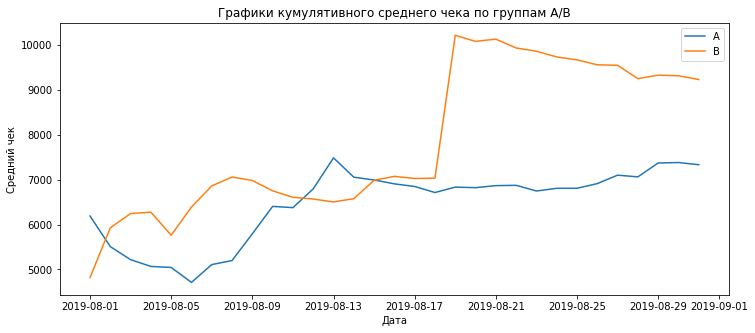

In [19]:
#разделим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize=(12,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.legend() 
plt.show()

На данном графике мы видим, что стабильно средний чек в группе B выше, но начиная с "18" августа 2019 года в группе B резкий рост среднего чека, что может быть связано с аномалиями.

#### 8. Строим график относительного изменения кумулятивного среднего чека группы B к группе A. Делаем выводы и предположения.

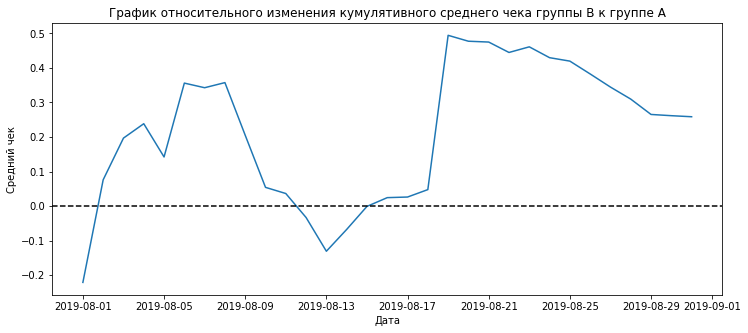

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

Видим очень резкие колебания графика в некоторых точках, - в данных явно есть выбросы, мы найдем их позже. 

#### 9. Строим график кумулятивного среднего количества заказов на посетителя по группам. Делаем выводы и предположения.

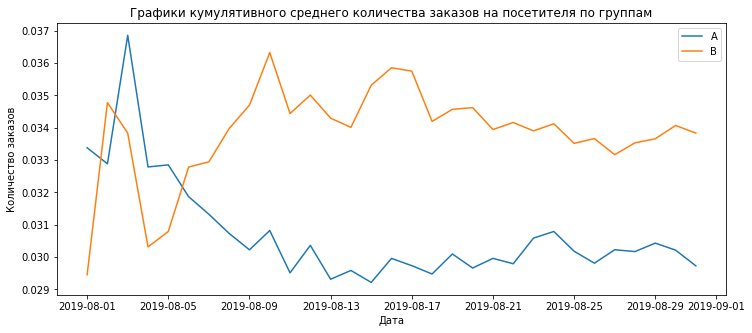

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','orders', 'visitors']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','orders', 'visitors']]

plt.figure(figsize=(12,5))

# Строим график количества заказов на посетителя в группе А
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders']/cumulativeOrdersA['visitors'], label='A')

# Строим график количества заказов на посетителя в группе B
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders']/cumulativeOrdersB['visitors'], label='B')

plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего количества заказов на посетителя по группам')
plt.legend() 
plt.show()

По графику видно, что больше заказов у посетителей в группе B.

#### 10. Строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Делаем выводы и предположения.

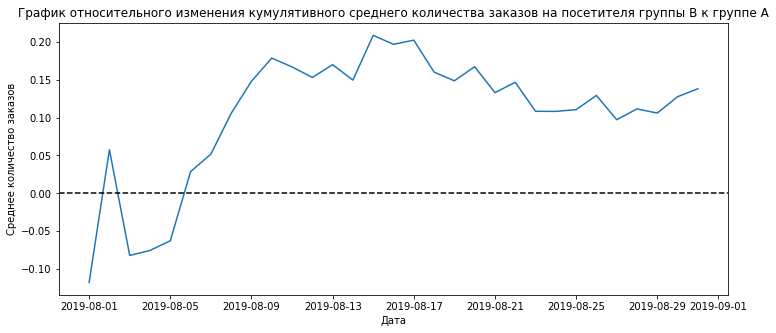

In [22]:
# собираем данные в одном датафрейме
mergedCumulativeOrders = cumulativeOrdersA.merge(cumulativeOrdersB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))

# cтроим отношение среднего количества заказов
plt.plot(mergedCumulativeOrders['date'], 
         (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])/(mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.ylabel('Среднее количество заказов')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе А')
plt.show()

Видим резкие изменения в начале графика - заказов было очень мало, а затем стало намного больше. Вероятно, была запущена какая-то маркетинговая акция, которая повлияла на рост заказов.

#### 11. Строим точечный график количества заказов по пользователям. Делаем выводы и предположения.

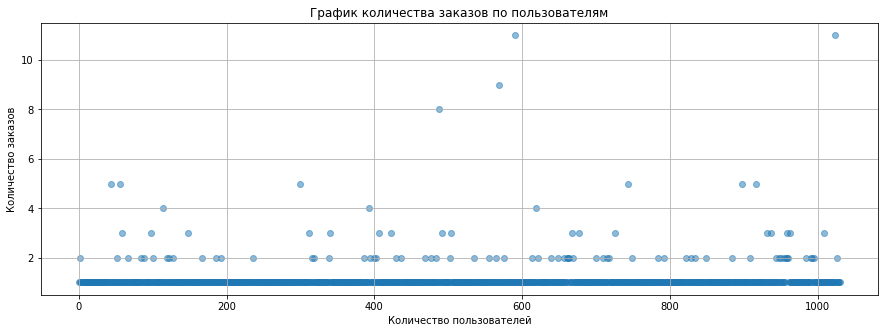

In [23]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5) ;

Исходя из точечного графика большинство пользователей делают не более 4 заказов.

#### 12. Cчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выбираем границу для определения аномальных пользователей.

In [24]:
percentiles = np.percentile(ordersByUsers['orders'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 2.0
99: 4.0


Не более 5% пользователей оформляли больше чем 2 заказа. 
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

#### 13. Строим точечный график стоимостей заказов. Делаем выводы и предположения.

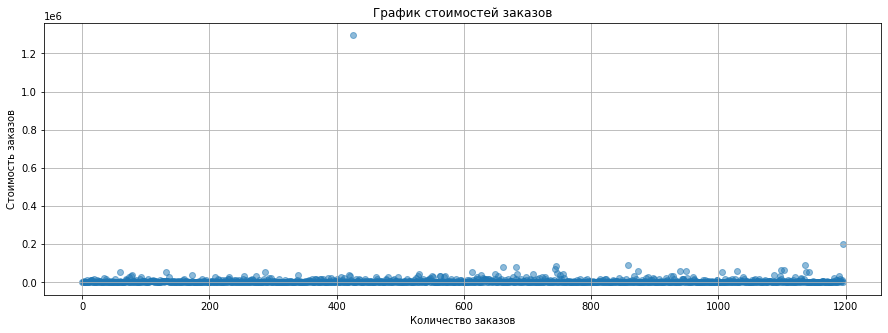

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.5);

Видим очень большой выброс - стоимость заказа свыше 1 200 000! Уберем этот выброс и посмотрим график снова.

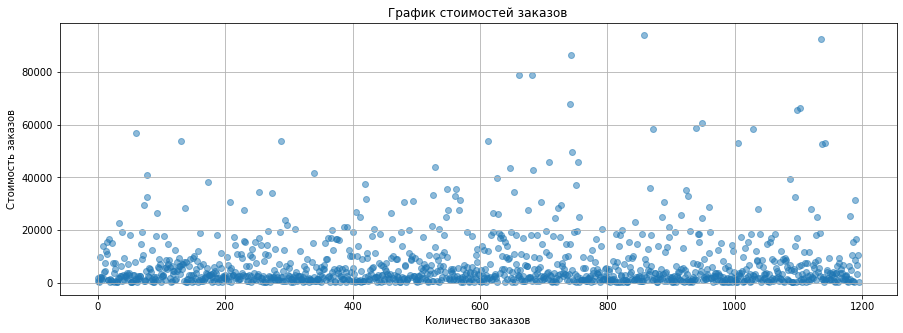

In [26]:
i_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(i_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')
plt.scatter(xn_values, i_orders, alpha=0.5);

В среднем стоимость всех заказов находится до 60 000.

#### 14. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выбераем границу для определения аномальных заказов.

In [27]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 28000.000000000004
99: 58233.19999999999


99% заказов стоят меньше 58233.2, - возьмем эту сумму в качестве определения границы для последующего расчета значений с "очищенными" данными.

#### 15. Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

In [28]:
#готовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [29]:
#cоздадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [30]:
#устанавливаем нули для пользователей, которые ничего не заказывали
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [31]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Сформулируем гипотезы.
Нулевая гипотеза: "в среднем количестве заказов на пользователя между группами в "сырых данных" нет статистически значимых различий". Альтернативная гипотеза: "в среднем количестве заказов на пользователя между группами в "сырых данных" есть статистически значимые различия".

In [32]:
#применяем критерий и отформатируем p-value, - округлим его до трех знаков после запятой
#объявляем переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя, а 
#пользователям без заказов нули
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#применяем тест Манна-Уитни
print('В среднем количестве заказов на пользователя между группами в "сырых данных" есть статистически значимые различия, т.к. P-value составляет:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
#вычисляем и выводим относительное различие в среднем между группами
print('Значение прироста среднего группы B к конверсии группы A равен:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

В среднем количестве заказов на пользователя между группами в "сырых данных" есть статистически значимые различия, т.к. P-value составляет: 0.017
Значение прироста среднего группы B к конверсии группы A равен: 0.138


#### 16. Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Делаем выводы и предположения.

Чтобы рассчитать статистическую значимость различий в среднем чеке между группами по "сырым" данным, передадим критерию mannwhitneyu() данные о выручке с заказов (пороговое значение возьмём равное 5%). И найдём относительные различия в среднем чеке между группами.

За нулевую гипотезу возьмём что: "статистически значимых различий в средних чеках между группами нет"; тогда альтернативная гипотеза будет гласить - статистически значимые различия есть.

In [33]:
print('Статически значимых отличий в среднем чеке между группами нет, т.к. P-value составляет:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами составляет:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Статически значимых отличий в среднем чеке между группами нет, т.к. P-value составляет: 0.729
Относительное различие среднего чека между сегментами составляет: 0.259


#### 17. Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Делаем выводы и предположения.

Сначала подготовим очищенные от аномалий данные. Сделаем срезы пользователей с числом заказов больше 2 - `usersWithManyOrders` и пользователей, совершивших заказы дороже 58233 - `UsersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`, удалим дубликаты, отсортируем по возрастанию.

In [36]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099    148427295
18      199603092
23      237748145
37      249864742
42      366673373
dtype: int64


In [ ]:
ordersByUsersA[ordersByUsersA['orders'] >= np.percentile(ordersByUsers['orders'], 95)]['userId']

Нулевая гипотеза: "статистически значимых различий в конверсии между группами нет".
Альтернативная гипотеза: "статистически значимые различия есть".

In [35]:
#создаем переменные, в которых сохраняем очищенные данные о заказах - не включая аномальных пользователей 
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
#выводим p-value для сравнения среднего между очищенными группами
print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
#выводим относительный прирост среднего очищенной группы B
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.01007
0.174


Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, - отвергаем, p-value 0.01 - меньше 0.05. 
Сегмент B значительно лучше сегмента А.

#### 18. Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Нулевая гипотеза: "статистически значимых различий средних чеков после удаления аномальных пользователей между группами нет".
Альтернативная гипотеза: "статистически значимые различия есть".

In [36]:
#выводим p-value для сравнения средних чеков между очищенными группами
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
#выведем относительный прирост среднего чека очищенной группы B
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.798
-0.020


P-value больше 0.05 - нулевую гипотезу о том, что статистически значимых различий средних чеков после удаления аномальных пользователей между группами нет, - не отвергаем. 
В сырых данных средний чек группы B ниже среднего чека группы А - такое произошло из-за выбросов, которые мы исключили на данном этапе анализа.

#### 19. Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным с учетом исключения пользователей, состоящих в двух группах одновременно.

In [37]:
#пересекающихся пользователей исключаю таким образом
orders = orders.drop_duplicates(subset=['visitorId', 'group'], keep=False)
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,)

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64


In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
#выводим p-value для сравнения среднего между очищенными группами
print('В среднем количестве заказов на пользователя между группами в "очищенных данных" с учетом исключения пользователей, состоящих в двух группах, есть статистически значимые различия, т.к. P-value составляет:', '{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
#выводим относительный прирост среднего очищенной группы B
print('Значение прироста среднего группы B к конверсии группы A равен:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

В среднем количестве заказов на пользователя между группами в "очищенных данных" с учетом исключения пользователей, состоящих в двух группах, есть статистически значимые различия, т.к. P-value составляет: 0.01666
Значение прироста среднего группы B к конверсии группы A равен: 0.160


#### 20. Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным  с учетом исключения пользователей, состоящих в двух группах одновременно. 

In [41]:
#выводим p-value для сравнения средних чеков между очищенными группами
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
#выведем относительный прирост среднего чека очищенной группы B
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.952
0.010


P-value больше 0.05 - нулевую гипотезу о том, что статистически значимых различий средних чеков после удаления аномальных пользователей между группами и удаления пользователей, состоящих в двух группах, нет, - не отвергаем. После удаления аномальных данных и пользователей, состоящих в двух группах средний чек группы B чуть выше среднего чека группы А (этот показатель отличается от того, который мы нашли, удалив только выбросы). 

### Вывод: тест можно остановить, фиксируем победу группы B. 

Мы выяснили, что у нас в двух группах есть пересекающиеся пользователи: их 58, удаление пересекающихся пользователей на общий вывод не повлияло. Кумулятивная выручка в группе B выше, чем в группе А, несмотря на то, что средний чек в двух группах примерно одинаков. Заказов стабильно больше в группе B, чем в группе A (это подтверждается как исследованием по "сырым" данным, так и по "очищенным" данным). 